In [1]:
%matplotlib inline
import os, glob, tifffile, cv2, gc
import openslide
import skimage.io
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [2]:
os.listdir('../input/prostate-cancer-grade-assessment')

['train_label_masks',
 'train.csv',
 'train_images',
 'test.csv',
 'sample_submission.csv']

---
## EDA - Tabular

In [3]:
data_dir = '../input/prostate-cancer-grade-assessment'
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [4]:
print(train.shape)
train.head()

(10616, 4)


,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


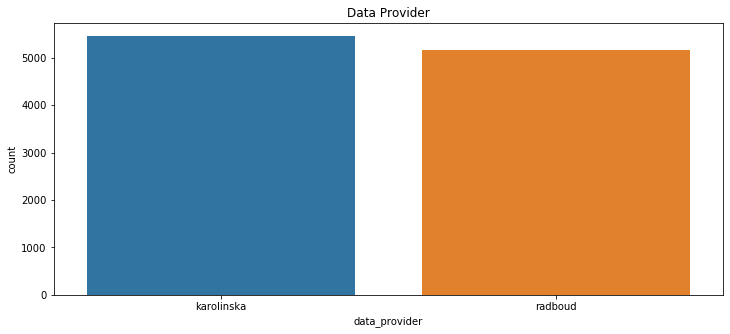

In [5]:
fig = plt.figure(figsize=(12, 5), facecolor='w')
sns.countplot(train['data_provider'])
plt.title('Data Provider')
plt.show()

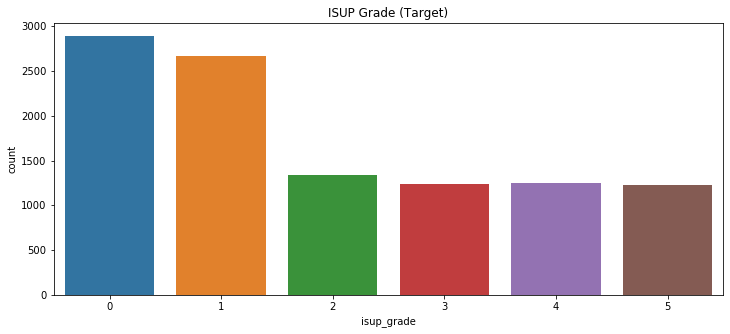

In [6]:
fig = plt.figure(figsize=(12, 5), facecolor='w')
sns.countplot(train['isup_grade'])
plt.title('ISUP Grade (Target)')
plt.show()

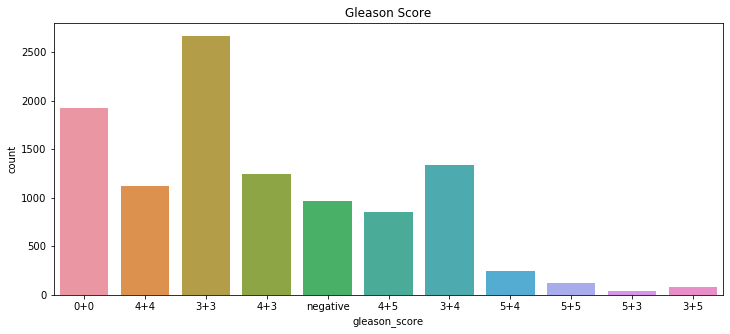

In [7]:
fig = plt.figure(figsize=(12, 5), facecolor='w')
sns.countplot(train['gleason_score'])
plt.title('Gleason Score')
plt.show()

---
## Distribution Target per Gleason Score

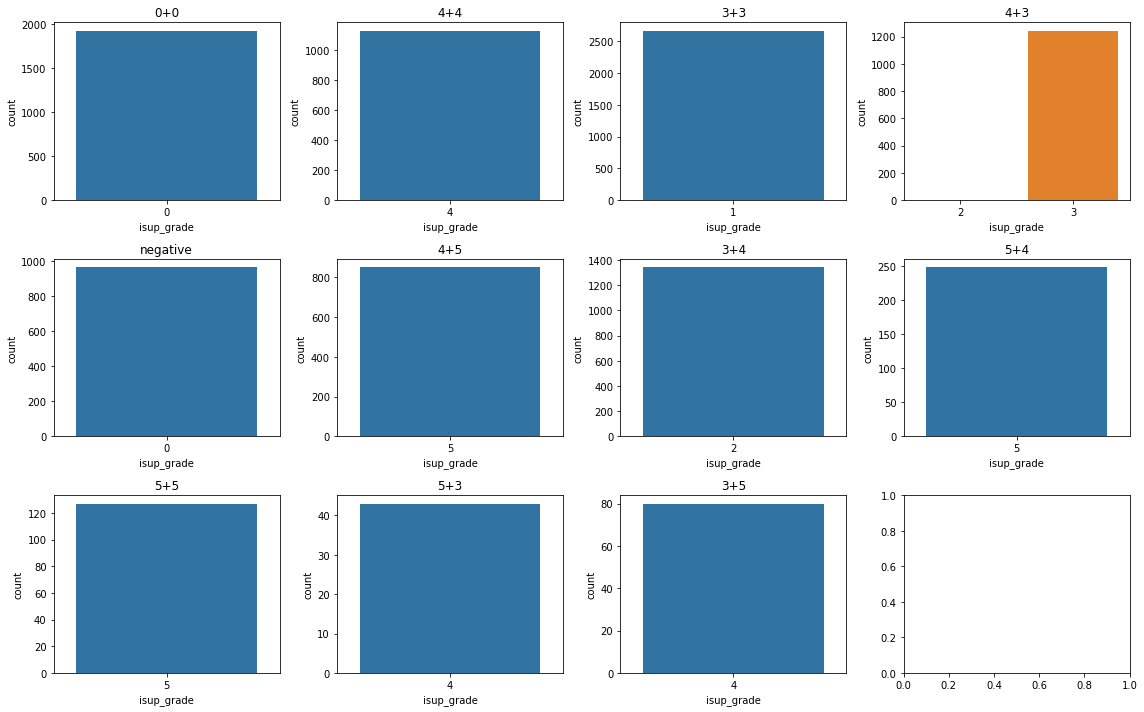

In [8]:
score_num = train['gleason_score'].nunique()
fig, axes = plt.subplots(ncols=4, nrows=int(np.ceil(score_num / 4)), figsize=(16, 10), facecolor='w')

for score, ax in zip(train['gleason_score'].unique(), axes.ravel()):
    temp = train[train['gleason_score'] == score]
    sns.countplot(temp['isup_grade'], ax=ax)
    ax.set_title(score)
    
plt.tight_layout()
plt.show()

One-to-one relationship between "isup_grade" and "gleason_score"

But there is only one exception (probably wrong)

In [9]:
# isup_grade = 2 and gleason_score = "4+3"
a = train[train['isup_grade'] == 2]
a[a['gleason_score'] == '4+3']

,image_id,data_provider,isup_grade,gleason_score
7273,b0a92a74cb53899311acc30b7405e101,karolinska,2,4+3


Focus on "0+0" and "negative"

In [10]:
train[train['gleason_score'] == 'negative']['data_provider'].unique()

array(['radboud'], dtype=object)

In [11]:
train[train['gleason_score'] == '0+0']['data_provider'].unique()

array(['karolinska'], dtype=object)

Labeled 0 + 0 or negative depending on data provider

    radboud -> "negative"
    karolinska -> "0+0"

In [12]:
# Modify label
train.loc[train['gleason_score'] == 'negative', 'gleason_score'] = '0+0'
train.loc[train['isup_grade'] == 2, 'gleason_score'] = '3+4'

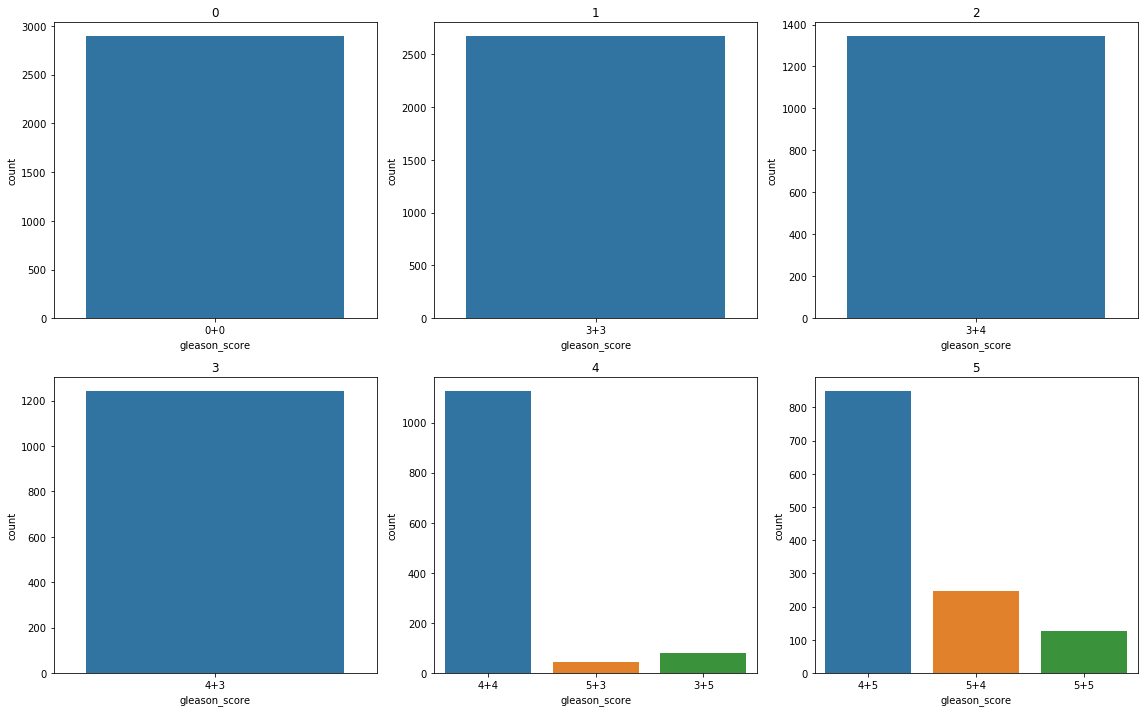

In [13]:
score_num = train['isup_grade'].nunique()
fig, axes = plt.subplots(ncols=3, nrows=int(np.ceil(score_num / 4)), figsize=(16, 10), facecolor='w')

for score, ax in zip(sorted(train['isup_grade'].unique()), axes.ravel()):
    temp = train[train['isup_grade'] == score]
    sns.countplot(temp['gleason_score'], ax=ax)
    ax.set_title(score)
    
plt.tight_layout()
plt.show()

isup_grades (< 4) are depended on Single "gleason_score".

isup_grades (>= 4) are depended on Multi "gleason_score".

---
## EDA - Image


For image visualization, refer to the following kernel.

https://www.kaggle.com/wouterbulten/getting-started-with-the-panda-dataset

In [14]:
train_imgs = glob.glob(os.path.join(data_dir, 'train_images/*.tiff'))
train_imgs = sorted(train_imgs)
print(len(train_imgs))
train_imgs[:3]

10616


['../input/prostate-cancer-grade-assessment/train_images/0005f7aaab2800f6170c399693a96917.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/000920ad0b612851f8e01bcc880d9b3d.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/0018ae58b01bdadc8e347995b69f99aa.tiff']

In [15]:
train_masks = glob.glob(os.path.join(data_dir, 'train_label_masks/*.tiff'))
train_masks = sorted(train_masks)
print(len(train_masks))
train_masks[:3]

10516


['../input/prostate-cancer-grade-assessment/train_label_masks/0005f7aaab2800f6170c399693a96917_mask.tiff',
 '../input/prostate-cancer-grade-assessment/train_label_masks/000920ad0b612851f8e01bcc880d9b3d_mask.tiff',
 '../input/prostate-cancer-grade-assessment/train_label_masks/0018ae58b01bdadc8e347995b69f99aa_mask.tiff']

In [16]:
def display_img(img_id, show_img=True, tiff_level=-1):
    img_path = os.path.join(data_dir, 'train_images', f'{img_id}.tiff')
    # Using Openslide
    slide = openslide.OpenSlide(img_path)
    # Set Properties  1: Point   2: Tiff Level   3: Viewing Dimension
    # .level_count -> Get Tiff Level Count
    # .level_dimensions -> Get Tiff Width, Height per Level
    if tiff_level == -1:
        patch = slide.read_region((0, 0), slide.level_count - 1, slide.level_dimensions[-1])
    else:
        patch = slide.read_region((0, 0), tiff_level, slide.level_dimensions[tiff_level])
    
    if show_img:
        display(patch)
        
    # PIL -> ndarray
    patch = np.asarray(patch)
    # RGBA -> RGB
    if patch.shape[-1] == 4:
        patch = patch[:, :, :3]
        
    slide.close()
    
    return patch


def display_mask(img_id, center, show_img=True, tiff_level=-1):
    assert center in ['radboud', 'karolinska'], "Please Set center=['radboud', 'karolinska']"
    
    img_path = os.path.join(data_dir, 'train_label_masks', f'{img_id}_mask.tiff')
    # Using Openslide
    slide = openslide.OpenSlide(img_path)
    # Set Properties  1: Point   2: Tiff Level   3: Viewing Dimension
    # .level_count -> Get Tiff Level Count
    # .level_dimensions -> Get Tiff Width, Height per Level
    if tiff_level == -1:
        mask_data = slide.read_region((0, 0), slide.level_count - 1, slide.level_dimensions[-1])
    else:
        mask_data = slide.read_region((0, 0), tiff_level, slide.level_dimensions[tiff_level])
    
    mask_data = mask_data.split()[0]
    # To show the masks we map the raw label values to RGB values
    preview_palette = np.zeros(shape=768, dtype=int)
    if center == 'radboud':
        # Mapping: {0: background(Black), 1: stroma(Dark Gray), 2: benign epithelium(Light Gray), 3: Gleason 3(Pale Yellow), 4: Gleason 4(Orange), 5: Gleason 5(Red)}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif center == 'karolinska':
        # Mapping: {0: background(Black), 1: benign(Gray), 2: cancer(Red)}
        preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
    mask_data.putpalette(data=preview_palette.tolist())
    mask_data = mask_data.convert(mode='RGB')
    if show_img:
        display(mask_data)
        
    # PIL -> ndarray
    mask_data = np.asarray(mask_data)
    # RGBA -> RGB
    if mask_data.shape[-1] == 4:
        mask_data = mask_data[:, :, :3]
        
    slide.close()
    
    return mask_data

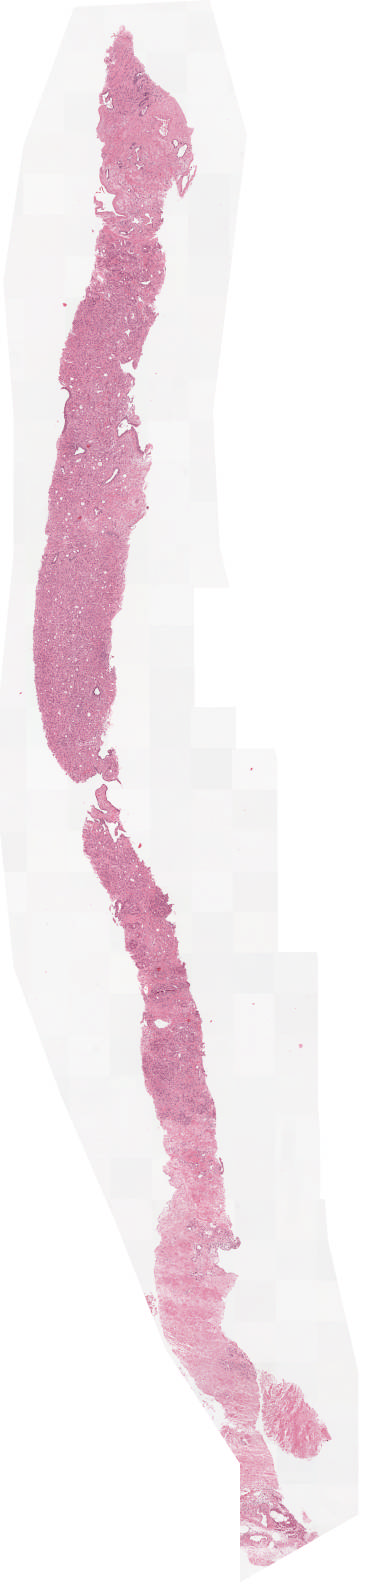

In [17]:
img = display_img('0018ae58b01bdadc8e347995b69f99aa')

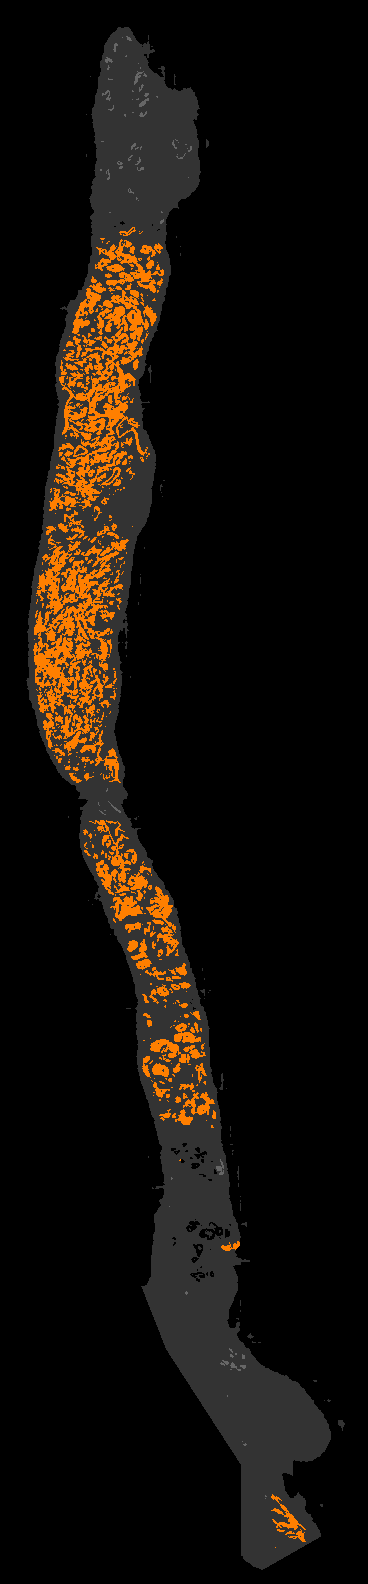

In [18]:
# Mask Data: Those judged to be cancer
mask = display_mask('0018ae58b01bdadc8e347995b69f99aa', 'radboud')

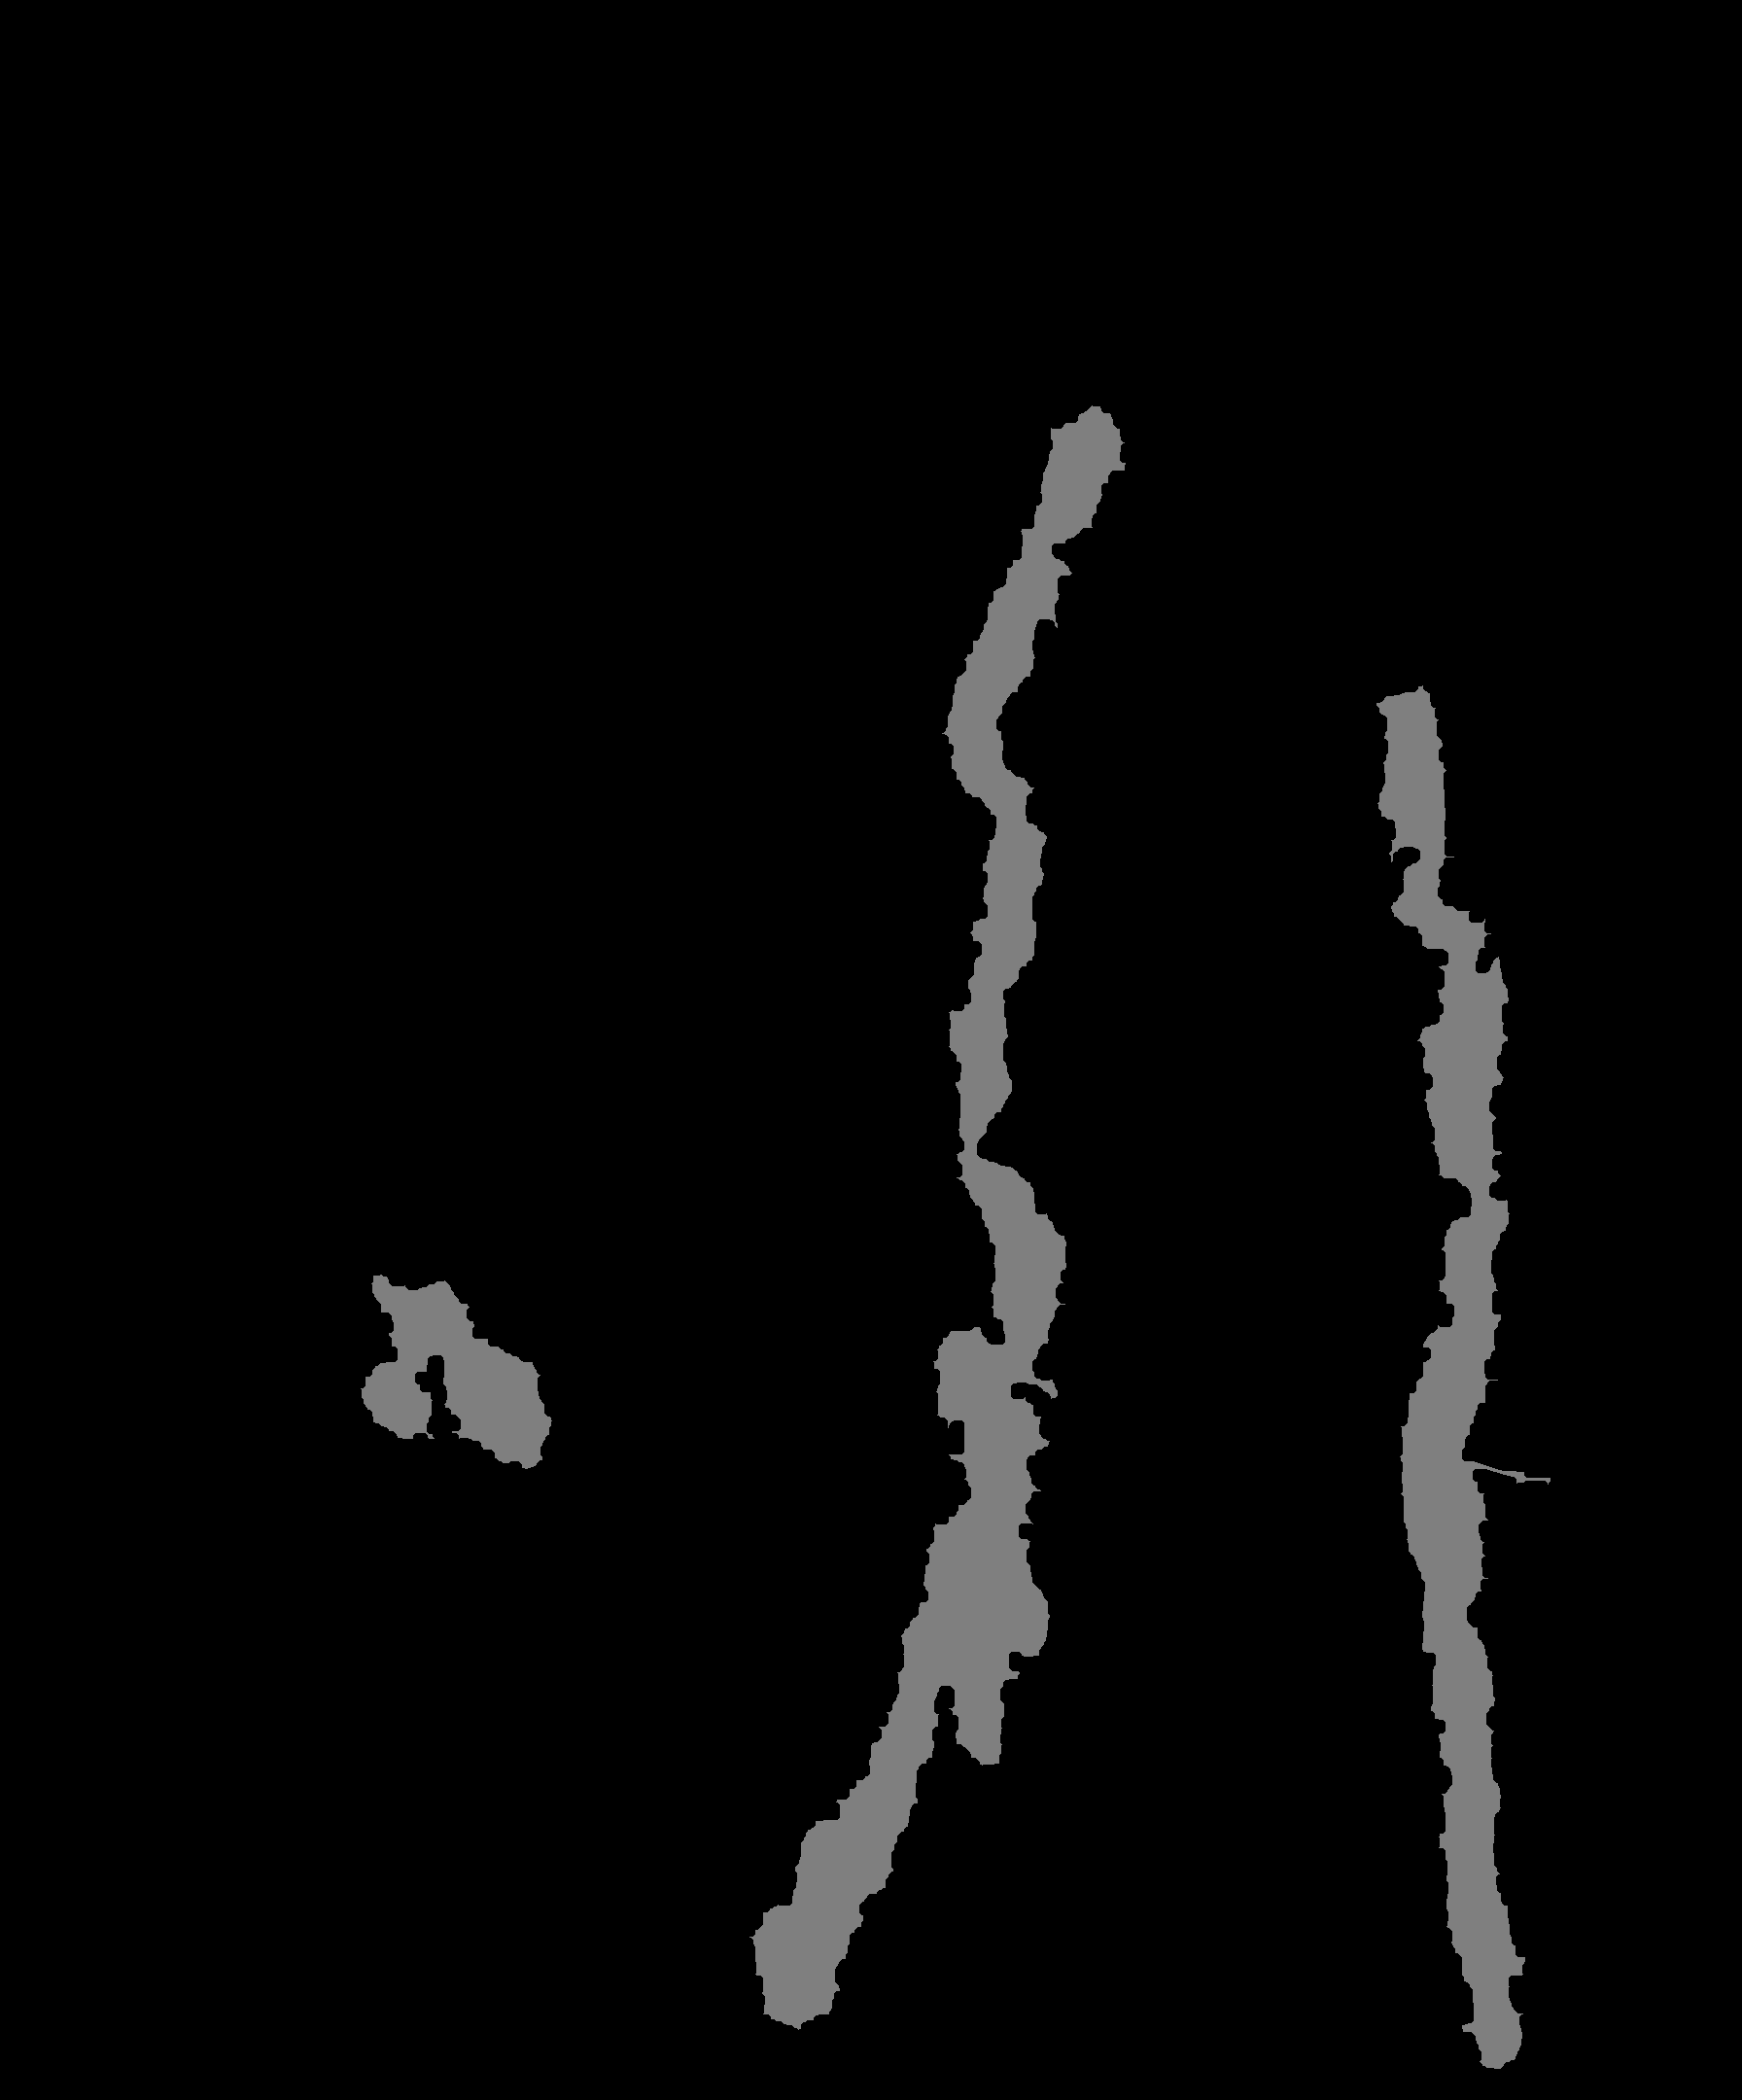

In [19]:
# Mask Data: Those judged not to be cancer
mask = display_mask('001d865e65ef5d2579c190a0e0350d8f', 'karolinska')

In [20]:
train.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [21]:
score_list = train['gleason_score'].unique()
score_list

array(['0+0', '4+4', '3+3', '4+3', '4+5', '3+4', '5+4', '5+5', '5+3',
       '3+5'], dtype=object)

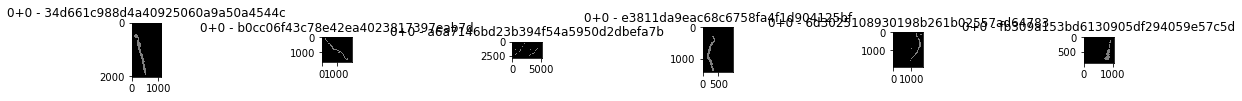

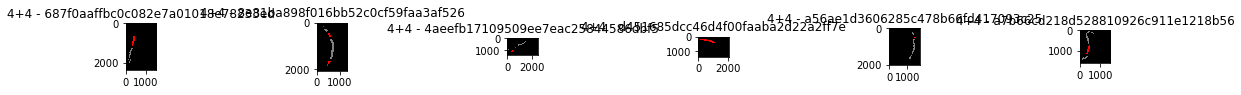

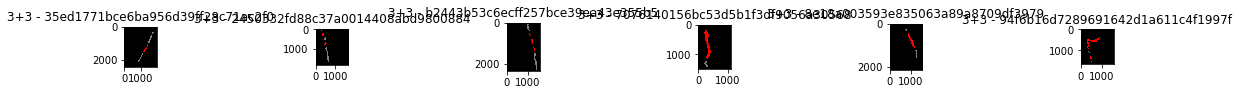

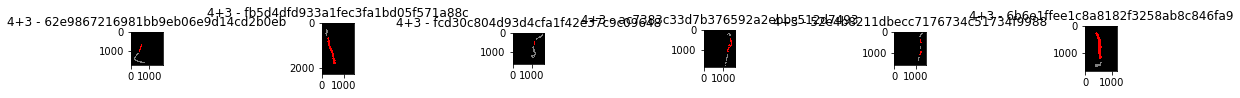

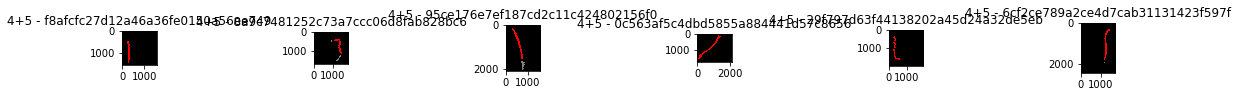

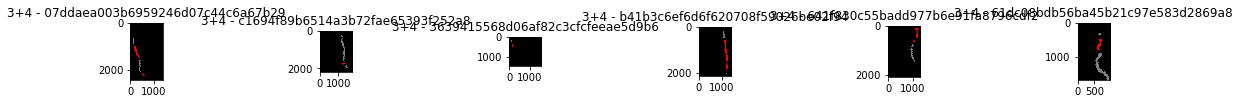

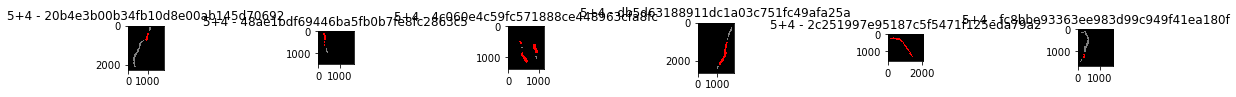

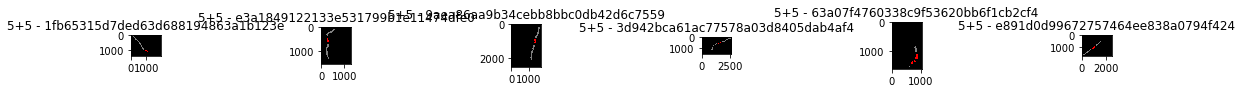

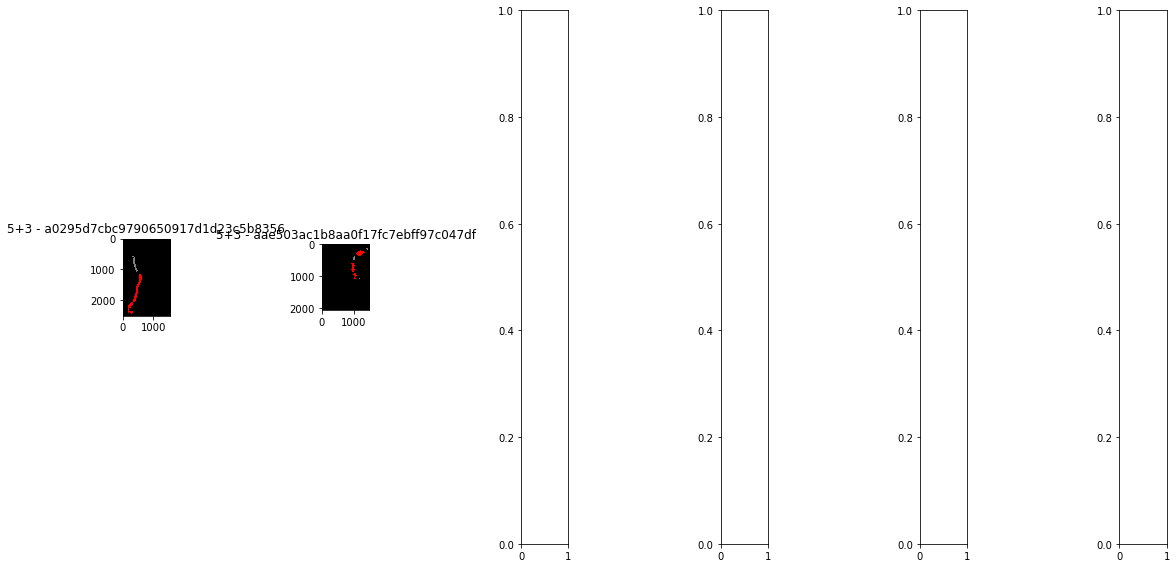

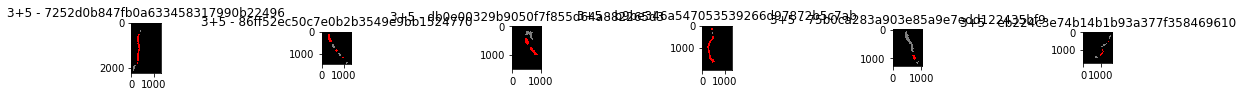

In [22]:
# Show mask data for each gleason_score (karolinska)

# Extract only images with mask data
mask_ids = glob.glob(os.path.join(data_dir, 'train_label_masks/*.tiff'))
mask_ids = [id.split('/')[4].split('_')[0] for id in mask_ids]
mask_ids[:6]
_train = train[train['image_id'].isin(mask_ids)]

_train = _train[_train['data_provider'] == 'karolinska']

for score in score_list:
    temp = _train[_train['gleason_score'] == score].sample(frac=1.0)
    
    ids = temp.head(6)['image_id'].values
    data_provider = temp.head(6)['data_provider'].values
    
    fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(16, 8), facecolor='w')
    for _id, provider, ax in zip(ids, data_provider, axes.ravel()):
        mask = display_mask(_id, provider, show_img=False)
        ax.imshow(mask)
        ax.set_title('{} - {}'.format(score, _id))
    plt.tight_layout()
    plt.show()

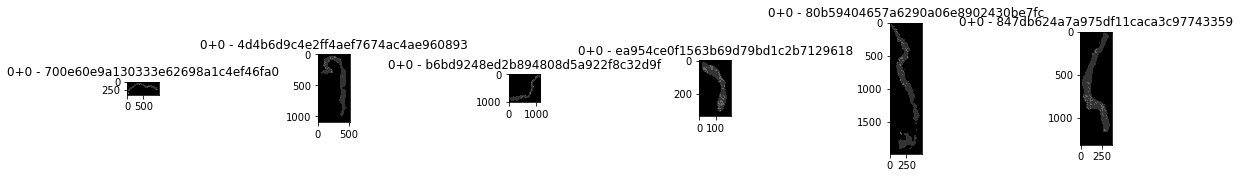

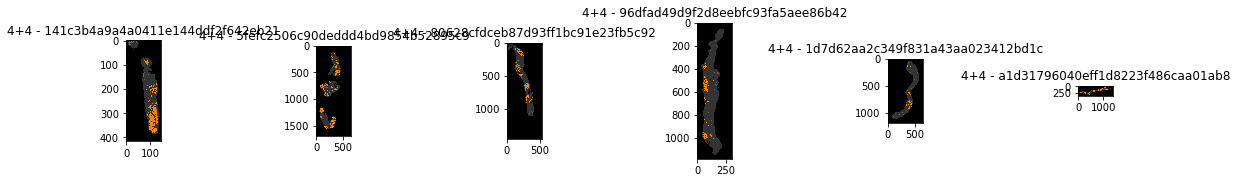

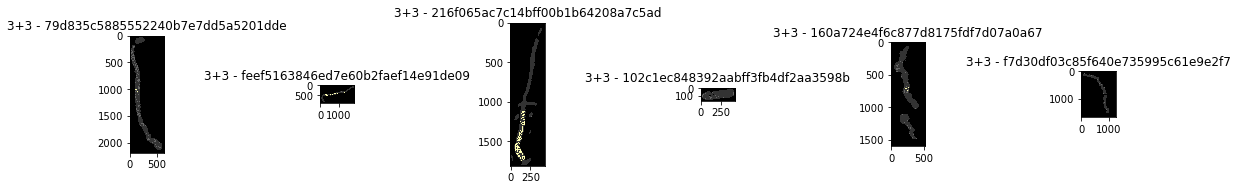

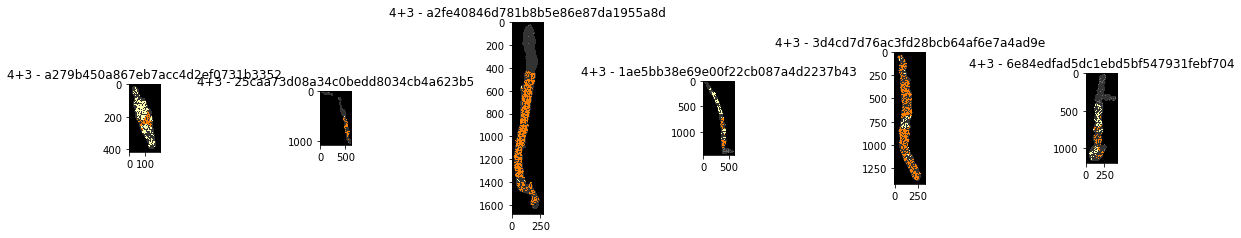

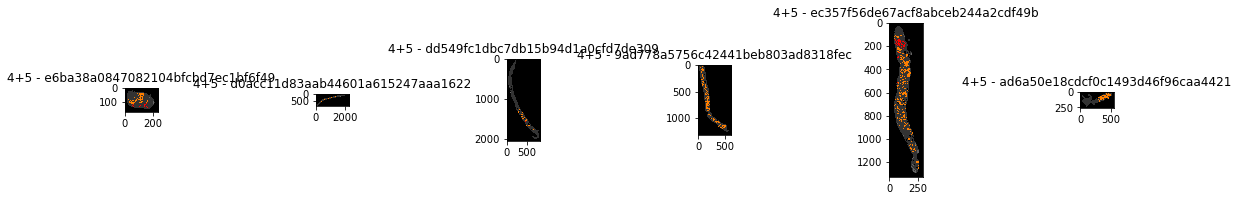

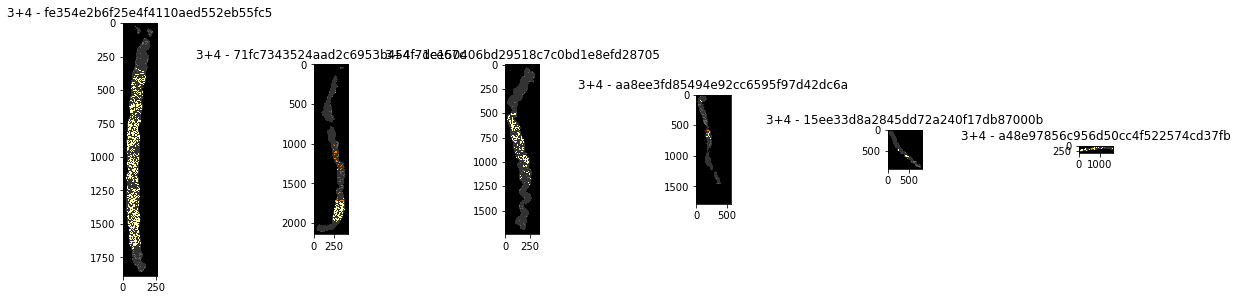

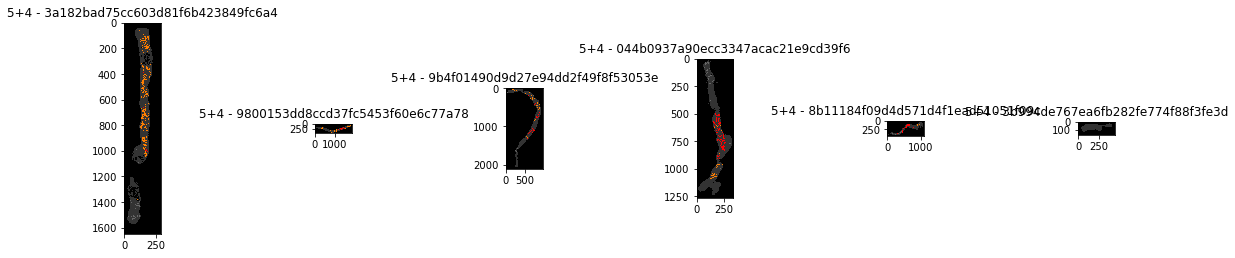

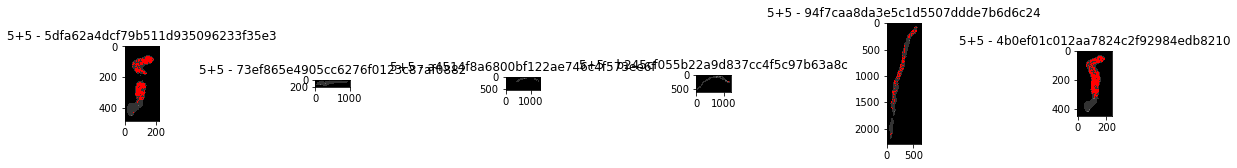

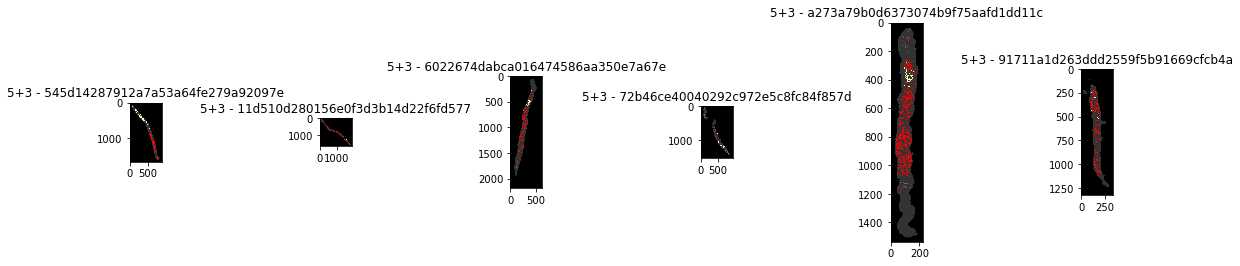

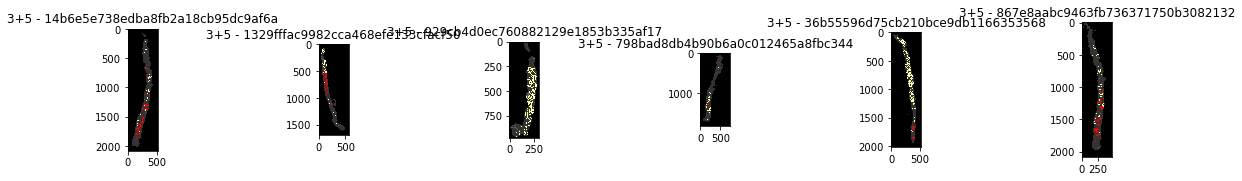

In [23]:
# Show mask data for each gleason_score (radboud)

# Extract only images with mask data
mask_ids = glob.glob(os.path.join(data_dir, 'train_label_masks/*.tiff'))
mask_ids = [id.split('/')[4].split('_')[0] for id in mask_ids]
mask_ids[:6]
_train = train[train['image_id'].isin(mask_ids)]

_train = _train[_train['data_provider'] == 'radboud']

for score in score_list:
    temp = _train[_train['gleason_score'] == score].sample(frac=1.0)
    
    ids = temp.head(6)['image_id'].values
    data_provider = temp.head(6)['data_provider'].values
    
    fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(16, 8), facecolor='w')
    for _id, provider, ax in zip(ids, data_provider, axes.ravel()):
        mask = display_mask(_id, provider, show_img=False)
        ax.imshow(mask)
        ax.set_title('{} - {}'.format(score, _id))
    plt.tight_layout()
    plt.show()

---
## Hypothesis

Relationship between gleason_score and isup_grade (hypothesis)


Mask (Radboud) Definition

Radboud: Prostate glands are individually labelled. Valid values are:

    0: background (non tissue) or unknown
    1: stroma (connective tissue, non-epithelium tissue)
    2: healthy (benign) epithelium
    3: cancerous epithelium (Gleason 3)
    4: cancerous epithelium (Gleason 4)
    5: cancerous epithelium (Gleason 5)


Looking at the mask data for each gleason_score, it is assumed that the gleason_score has the following definition.

    3+3: Almost cancerous epithelium (Gleason 3)
    3+4: Gleason 3 and Gleason 4 are mixed. The ratio is more Gleason 3
    4+3: Gleason 3 and Gleason 4 are mixed. The ratio is more Gleason 4


Summary:

    A+B: Gleason A and Gleason B are mixed. The ratio is more Gleason A


As mentioned above, isup_grade is determined by gleason_score

    3+3 = 1(isup_grade)
    4+3 = 2(isup_grade)
    5+5 = 5(isup_grade)

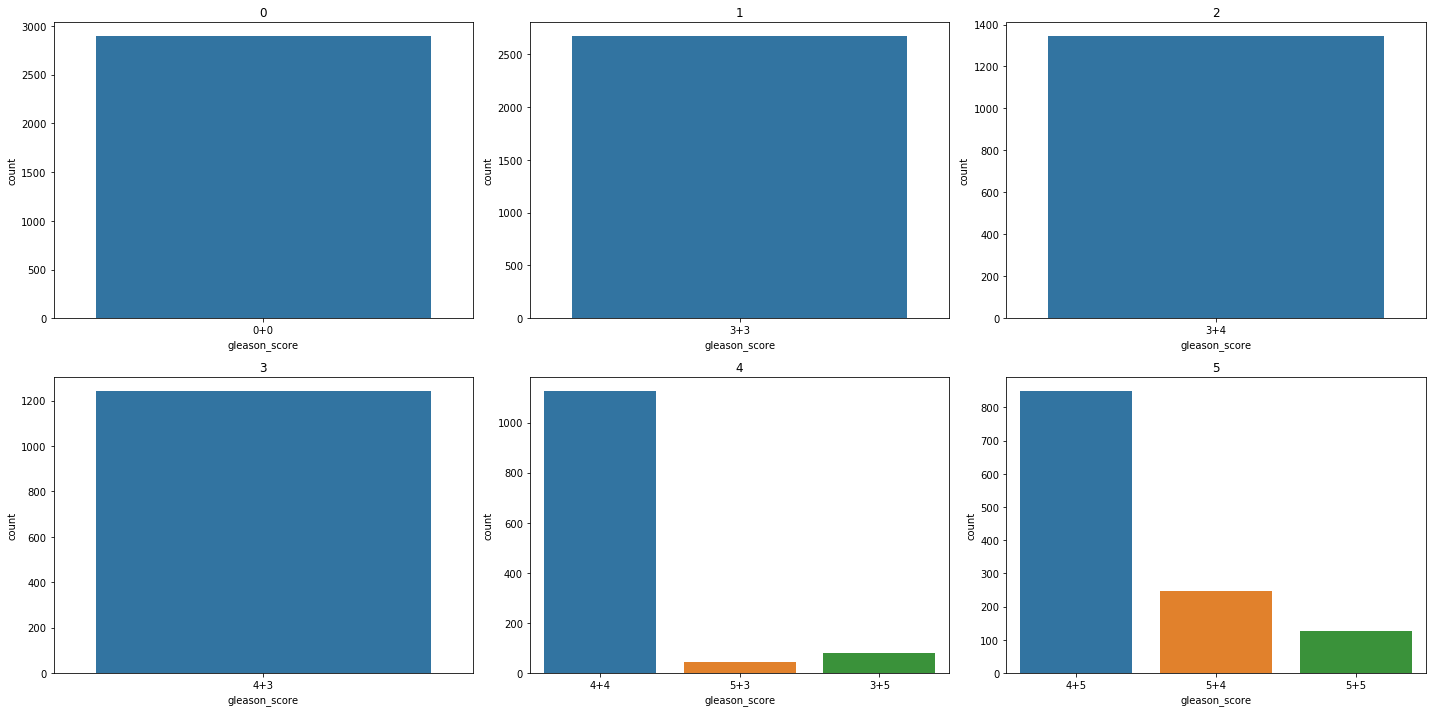

In [24]:
score_num = train['isup_grade'].nunique()
fig, axes = plt.subplots(ncols=3, nrows=int(np.ceil(score_num / 4)), figsize=(20, 10), facecolor='w')

for score, ax in zip(sorted(train['isup_grade'].unique()), axes.ravel()):
    temp = train[train['isup_grade'] == score]
    sns.countplot(temp['gleason_score'], ax=ax)
    ax.set_title(score)
    
plt.tight_layout()
plt.show()

What you need to find is to cut one image data with a grid and calculate the gleason_score for each grid.

Calculate isup_grade from the ratio of distribution based on the result calculated by it.

Convert RGB to glearson score

    0: background (non tissue) or unknown
    RGB: (0, 0, 0): Sum: 0 -> Gleason_score: 0

    1: stroma (connective tissue, non-epithelium tissue)
    RGB: (51, 51, 51): Sum: 153 -> Gleason_score: 1

    2: healthy (benign) epithelium
    RGB: (102, 102, 102): Sum: 306 -> Gleason_score: 1 (Meaning Healthy)

    3: cancerous epithelium (Gleason 3)
    RGB: (255, 255, 178): Sum: 688 -> Gleason_score: 3
    
    4: cancerous epithelium (Gleason 4)
    RGB: (255, 127, 0): Sum: 382 -> Gleason_score: 4

    5: cancerous epithelium (Gleason 5)
    RGB: (255, 0, 0): Sum: 255 -> Gleason_score: 5

In [25]:
# 高解像度の画像はtiff_level=0
# 3+3
mask = display_mask('98c7ea676add7df440b5893d776f7a6d', 'radboud', show_img=False, tiff_level=0)
mask.shape

(14592, 14080, 3)

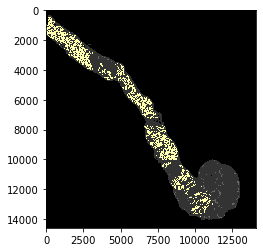

In [26]:
plt.imshow(mask)

In [27]:
del mask
gc.collect()

49339

In [28]:
def preprocessing_mask(mask):

    # RBG -> gleason_score
    _mask = np.sum(mask, axis=2)

    # 0: Background
    # 1: stroma = 153
    _mask = np.where(_mask==153, 1, _mask)
    # 2: benign epithelium = 306
    _mask = np.where(_mask==306, 1, _mask)  # Healthy
    # 3: Gleason 3 = 688  score=3
    _mask = np.where(_mask==688, 3, _mask)
    # 4: Gleason 4 = 382   score=4
    _mask = np.where(_mask==382, 4, _mask)
    # 5: Gleason 5 = 255   score=5
    _mask = np.where(_mask==255, 5, _mask)

    u, counts = np.unique(_mask, return_counts=True)
    score_dict = {k:v for k, v in zip(u, counts)}
    
    return _mask, score_dict

In [29]:
# Calculate percentage for each gleason_score
score = '3+3'
search_num = 5

temp = train[train['data_provider'] == 'radboud']
temp = temp[temp['gleason_score'] == score]

tar_ids = temp.sample(frac=1.0)['image_id'].values[:search_num]

for id in tar_ids:
    try:
        mask = display_mask(id, 'radboud', show_img=False, tiff_level=0)
    except:
        continue
        
    _, score_dict = preprocessing_mask(mask)
    
    try:
        rate = score_dict[3] / score_dict[1] * 100
    except:
        rate = 0
        
    print('#'*30)
    print('Image_id: ', id)
    print(score_dict)
    print(f'Score 3 / All   Rate: {rate:.3f}%')
    
    del mask
    gc.collect()

##############################
Image_id:  b6f6624565452fa6d2ca4edb00db4204
{0: 66144648, 1: 18255288, 3: 534720}
Score 3 / All   Rate: 2.929%
##############################
Image_id:  554c017aec32fb7b6448c3ba22d3f0e4
{0: 19145532, 1: 4728752, 3: 242964}
Score 3 / All   Rate: 5.138%
##############################
Image_id:  77a8d4500bd331027b965e1b1e581ab1
{0: 231518640, 1: 36128416, 3: 4982704}
Score 3 / All   Rate: 13.792%
##############################
Image_id:  f7956aab178ff4c161a505b6a050579f
{0: 108912204, 1: 23392204, 3: 602600}
Score 3 / All   Rate: 2.576%
##############################
Image_id:  a44fd7663c5ae9bfd375e6dc75b497f6
{0: 22209928, 1: 7981556, 3: 282756}
Score 3 / All   Rate: 3.543%


In [30]:
# Calculate percentage for each gleason_score
score = '3+4'
search_num = 5

temp = train[train['data_provider'] == 'radboud']
temp = temp[temp['gleason_score'] == score]

tar_ids = temp.sample(frac=1.0)['image_id'].values[:search_num]

for id in tar_ids:
    try:
        mask = display_mask(id, 'radboud', show_img=False, tiff_level=0)
    except:
        continue
        
    _, score_dict = preprocessing_mask(mask)
    
    try:
        rate_3 = score_dict[3] / (score_dict[1] + score_dict[4]) * 100
        rate_4 = score_dict[4] / (score_dict[1] + score_dict[3]) * 100
    except:
        rate_3 = 0
        rate_4 = 0
        
    print('#'*30)
    print('Image_id: ', id)
    print(score_dict)
    print(f'Score 3 / All   Rate: {rate_3:.3f}%')
    print(f'Score 4 / All   Rate: {rate_4:.3f}%')
    
    del mask
    gc.collect()

##############################
Image_id:  5c083ab21fc57c0954468ab46aa7fb16
{0: 162276872, 1: 21217336, 3: 6343848, 4: 6769944}
Score 3 / All   Rate: 22.667%
Score 4 / All   Rate: 24.563%
##############################
Image_id:  022544d1446c2c44f8ca8ff53262dc5b
{0: 89441552, 1: 25932988, 3: 5353628, 4: 513432}
Score 3 / All   Rate: 20.243%
Score 4 / All   Rate: 1.641%
##############################
Image_id:  fa6569eb827fcd7108ee7f22dac0ea11
{0: 156177200, 1: 26593028, 3: 8058200, 4: 864372}
Score 3 / All   Rate: 29.348%
Score 4 / All   Rate: 2.494%
##############################
Image_id:  70f71c6fa7ad2baeaff157a299e276a0
{0: 61954280, 1: 27401952, 3: 1314788, 4: 2717780}
Score 3 / All   Rate: 4.365%
Score 4 / All   Rate: 9.464%


In [31]:
# Calculate percentage for each gleason_score
score = '4+3'
search_num = 5

temp = train[train['data_provider'] == 'radboud']
temp = temp[temp['gleason_score'] == score]

tar_ids = temp.sample(frac=1.0)['image_id'].values[:search_num]

for id in tar_ids:
    try:
        mask = display_mask(id, 'radboud', show_img=False, tiff_level=0)
    except:
        continue
        
    _, score_dict = preprocessing_mask(mask)
    
    try:
        rate_3 = score_dict[3] / (score_dict[1] + score_dict[4]) * 100
        rate_4 = score_dict[4] / (score_dict[1] + score_dict[3]) * 100
    except:
        rate_3 = 0
        rate_4 = 0
        
    print('#'*30)
    print('Image_id: ', id)
    print(score_dict)
    print(f'Score 3 / All   Rate: {rate_3:.3f}%')
    print(f'Score 4 / All   Rate: {rate_4:.3f}%')
    
    del mask
    gc.collect()

##############################
Image_id:  5ad5cca8bc4c96585d42a6f8369be1e7
{0: 173831344, 1: 40818516, 3: 685484, 4: 12598864}
Score 3 / All   Rate: 1.283%
Score 4 / All   Rate: 30.356%
##############################
Image_id:  88281522d27ef85887810dcc0cb89b14
{0: 64255724, 1: 12051944, 3: 38296, 4: 13897108}
Score 3 / All   Rate: 0.148%
Score 4 / All   Rate: 114.945%
##############################
Image_id:  6d2cf90cf2df03cf1d9f2eb38362f58d
{0: 30194900, 1: 18638484, 3: 1251152, 4: 2016584}
Score 3 / All   Rate: 6.057%
Score 4 / All   Rate: 10.139%
##############################
Image_id:  d9c9948c3c66446410dfc95adcafd115
{0: 110791932, 1: 33987564, 3: 5350824, 4: 1257840}
Score 3 / All   Rate: 15.182%
Score 4 / All   Rate: 3.197%
##############################
Image_id:  1f8c98a43c6e755c2b3a785db72520e1
{0: 330759028, 1: 45832808, 3: 546356, 4: 9196528}
Score 3 / All   Rate: 0.993%
Score 4 / All   Rate: 19.829%


In [32]:
# Calculate percentage for each gleason_score
score = '5+4'
search_num = 5

temp = train[train['data_provider'] == 'radboud']
temp = temp[temp['gleason_score'] == score]

tar_ids = temp.sample(frac=1.0)['image_id'].values[:search_num]

for id in tar_ids:
    try:
        mask = display_mask(id, 'radboud', show_img=False, tiff_level=0)
    except:
        continue
        
    _, score_dict = preprocessing_mask(mask)
    
    try:
        rate_4 = score_dict[4] / (score_dict[1] + score_dict[5]) * 100
        rate_5 = score_dict[5] / (score_dict[1] + score_dict[4]) * 100
    except:
        rate_4 = 0
        rate_5 = 0
        
    print('#'*30)
    print('Image_id: ', id)
    print(score_dict)
    print(f'Score 4 / All   Rate: {rate_4:.3f}%')
    print(f'Score 5 / All   Rate: {rate_5:.3f}%')
    
    del mask
    gc.collect()

##############################
Image_id:  5b439c3bf2ed699b136dc5ca939873bc
{0: 447164792, 1: 29800188, 4: 13011176, 5: 757412}
Score 4 / All   Rate: 42.579%
Score 5 / All   Rate: 1.769%
##############################
Image_id:  80a9fb86cc68aade057a0e680f3e5c0a
{0: 87887072, 1: 25771540, 4: 6048508, 5: 27152}
Score 4 / All   Rate: 23.445%
Score 5 / All   Rate: 0.085%
##############################
Image_id:  78138d4fc0b8fceb04138cd44d4a4fdd
{0: 43655860, 1: 11537880, 4: 3764304, 5: 155428}
Score 4 / All   Rate: 32.192%
Score 5 / All   Rate: 1.016%
##############################
Image_id:  84d0f286cb639e7ceb3b185c62776100
{0: 58125984, 1: 15837480, 4: 8515104, 5: 1473048}
Score 4 / All   Rate: 49.190%
Score 5 / All   Rate: 6.049%
##############################
Image_id:  f4df16a55805e69f7013d79eca0c46a7
{0: 259893940, 1: 42821532, 4: 7049084, 5: 613940}
Score 4 / All   Rate: 16.229%
Score 5 / All   Rate: 1.231%


In [33]:
# Data Provider == 'radboud'
# Calculate percentage for each gleason_score

ids = []
gscore_list = []
rate_3_list = []
rate_4_list = []
rate_5_list = []
limit = 800

temp = train[train['data_provider'] == 'radboud']
temp = temp.sample(frac=1.0).head(limit)
tar_ids = temp['image_id'].values
gleason_score = temp['gleason_score'].values

for i in tqdm(range(len(temp))):
    id = tar_ids[i]
    gscore = gleason_score[i]
    
    try:
        mask = display_mask(id, 'radboud', show_img=False, tiff_level=0)
    except:
        continue
        
    _, score_dict = preprocessing_mask(mask)
    
    # Excluding background
    del score_dict[0]
    all_pix = np.sum([v for v in score_dict.values()])
    
    # Calculate percentage for each score
    try:
        rate_3 = score_dict[3] / all_pix * 100
    except:
        rate_3 = 0
    
    try:
        rate_4 = score_dict[4] / all_pix * 100
    except:
        rate_4 = 0
        
    try:
        rate_5 = score_dict[5] / all_pix * 100
    except:
        rate_5 = 0
        
    ids.append(id)
    gscore_list.append(gscore)
    rate_3_list.append(rate_3)
    rate_4_list.append(rate_4)
    rate_5_list.append(rate_5)
    
    del mask, score_dict
    gc.collect()
    
rate_res = pd.DataFrame({
    'image_id': ids,
    'gleason_score': gscore_list,
    'rate_3': rate_3_list,
    'rate_4': rate_4_list,
    'rate_5': rate_5_list
})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


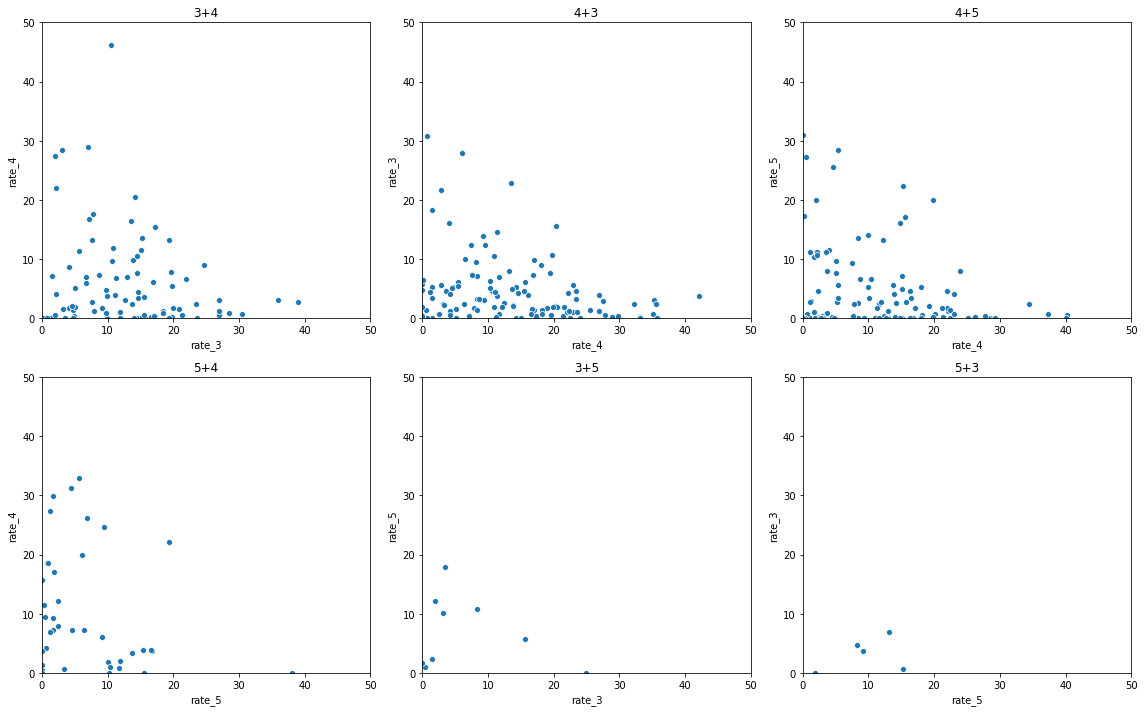

In [34]:
# ScatterPlot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), facecolor='w')
scores = ['3+4', '4+3', '4+5', '5+4', '3+5', '5+3']
for score, ax in zip(scores, axes.ravel()):
    temp = rate_res[rate_res['gleason_score'] == score]
    sns.scatterplot(x='rate_{}'.format(score.split('+')[0]), y='rate_{}'.format(score.split('+')[1]), data=temp, ax=ax)
    ax.set_ylim(0, 50)
    ax.set_xlim(0, 50)
    ax.set_title(score)
    
plt.tight_layout()
plt.show()

In [35]:
rate_res.to_csv('rate_res.csv', index=False)